# Churn-prediktion

End-to-end arbetsflöde för att analysera kundbeteenden och förutsäga churn – risken att en kund slutar handla.  
Från datainläsning och feature engineering till modellträning, utvärdering, kalibrering och export.

---
## Importer & Setup

In [1]:
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from IPython.display import display
from sklearn.base import clone
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [2]:
# Projektets root och src-mapp (setup, ej import)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
SRC_DIR = PROJECT_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# Lokala moduler
from data_prep import (
    build_features,
    clean_orders,
    compute_rfm,
    load_orders,
    make_api_config,
    make_paths,
)
from export import train_full_and_export
from model import (
    calibrate_model,
    cross_validate_auc,
    evaluate_model,
    get_models,
    train_compare,
)

In [3]:
# Globala inställningar
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", 100)
sns.set_theme(style="whitegrid", palette="muted")

# Konfiguration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

CHURN_DAYS = 90
PERM_REPEATS = 5  # demo; 10–20 i produktion
USE_CALIBRATED_FOR_EXPORT = False

# Filvägar
paths = make_paths(PROJECT_ROOT)

---
## Datainläsning & Rengöring

In [4]:
# API-inställningar
api_cfg = make_api_config()

# Ladda orderdata (API, CSV, XLSX eller dummy)
df, source = load_orders(paths, api_cfg)
if source == "dummy":
    print("⚠️ Running on dummy data - metrics may not be meaningful.")

# Grundläggande rensning
df = clean_orders(df)

# Referensdatum
reference_date = df["order_date"].max() + pd.Timedelta(days=1)

Ingen källa hittad, genererar dummy-data.


⚠️ Running on dummy data - metrics may not be meaningful.


---
## Explorativ Dataanalys (EDA)

### Sammanfattning 


In [5]:
pmin = df["order_date"].min()
pmax = df["order_date"].max()

eda_summary = pd.DataFrame(
    {
        "Metric": [
            "Source",
            "Rows",
            "Unique customers",
            "Period start",
            "Period end",
            "Orders per month (median)",
            "Order amount (mean)",
            "Order amount (median)",
        ],
        "Value": [
            source,
            f"{len(df):,}",
            f"{df['customer_id'].nunique():,}",
            pmin.strftime("%Y-%m-%d"),
            pmax.strftime("%Y-%m-%d"),
            int(df.set_index("order_date").resample("M").size().median()),
            f"{df['amount'].mean():.2f}",
            f"{df['amount'].median():.2f}",
        ],
    }
)
display(eda_summary)

,Metric,Value
0,Source,dummy
1,Rows,"5,000"
2,Unique customers,500
3,Period start,2023-12-05
4,Period end,2025-01-29
5,Orders per month (median),412
6,Order amount (mean),783.18
7,Order amount (median),753.88


### Distributioner (orderbelopp & volym)

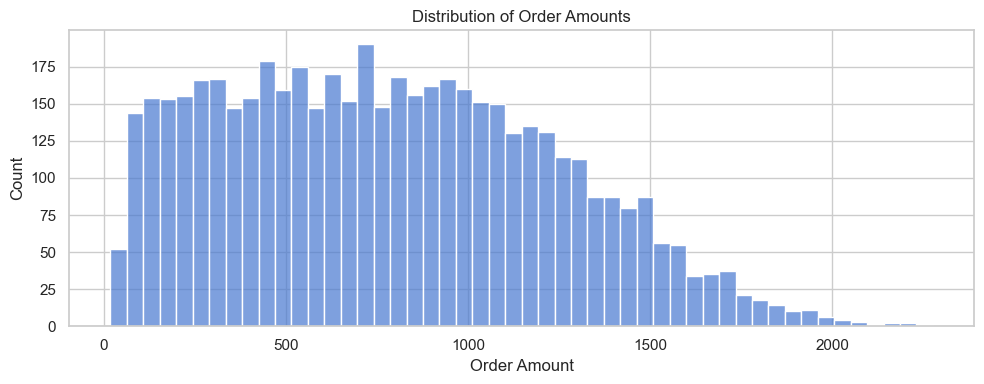

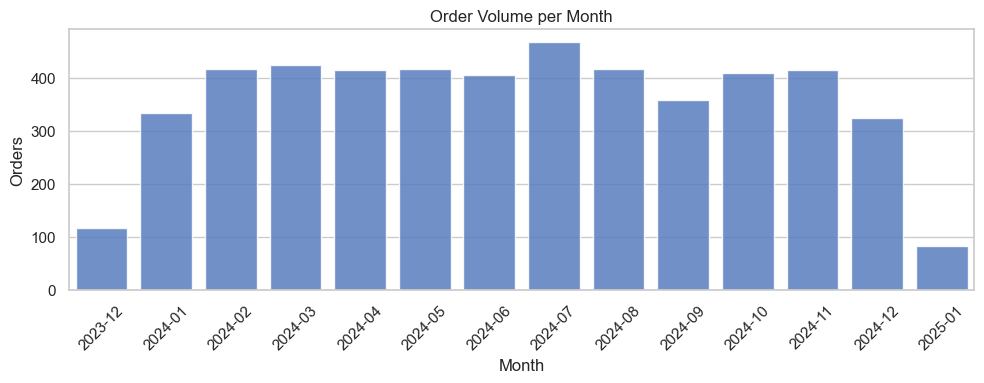

In [6]:
plt.figure(figsize=(10, 4))
sns.histplot(df["amount"], bins=50, alpha=0.7, kde=False)
plt.xlabel("Order Amount")
plt.ylabel("Count")
plt.title("Distribution of Order Amounts")
plt.tight_layout()
plt.show()

month_counts = (
    df.set_index("order_date")
      .resample("M")
      .size()
      .reset_index(name="n")
)

month_counts["month"] = month_counts["order_date"].dt.strftime("%Y-%m")

plt.figure(figsize=(10, 4))
sns.barplot(data=month_counts, x="month", y="n", alpha=0.85)
plt.xlabel("Month")
plt.ylabel("Orders")
plt.title("Order Volume per Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

   ### Recency & Klassfördelning

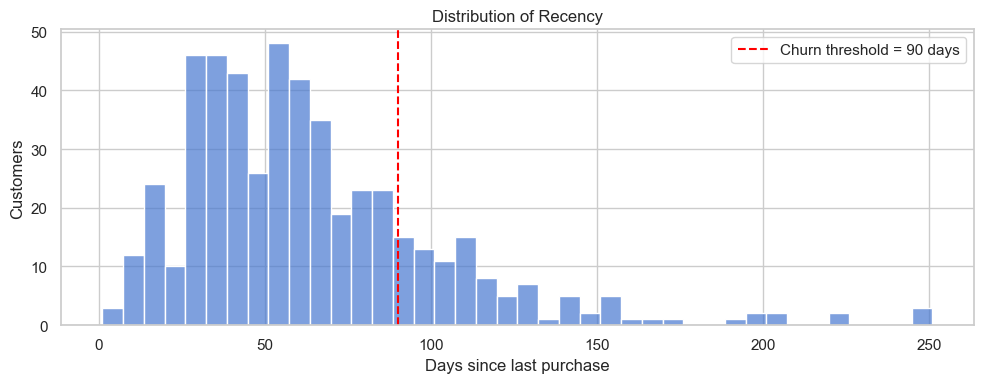

,status,Proportion,Proportion (%)
0,Active,0.814,81.4
1,Churned,0.186,18.6


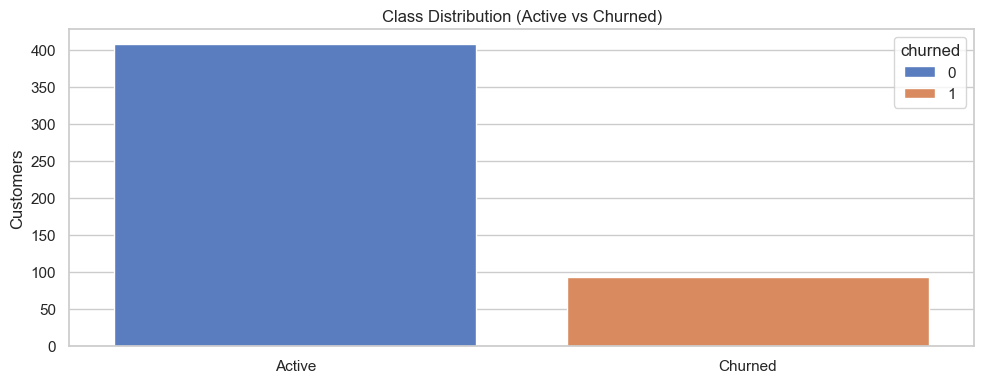

In [7]:
# Kundtabell för churn-analys
eda_feats = (
    df.groupby("customer_id").agg(last_purchase=("order_date", "max")).reset_index()
)
eda_feats["recency"] = (reference_date - eda_feats["last_purchase"]).dt.days
eda_feats["churned"] = (eda_feats["recency"] > CHURN_DAYS).astype(int)

# Visualisera recency med churn-tröskel
plt.figure(figsize=(10, 4))
sns.histplot(eda_feats["recency"], bins=40, alpha=0.7)
plt.axvline(
    CHURN_DAYS,
    color="red",
    linestyle="--",
    label=f"Churn threshold = {CHURN_DAYS} days",
)
plt.title("Distribution of Recency")
plt.xlabel("Days since last purchase")
plt.ylabel("Customers")
plt.legend()
plt.tight_layout()
plt.show()

cb = (
    eda_feats["churned"]
    .value_counts(normalize=True)
    .rename(index={0: "Active", 1: "Churned"})
    .round(3)
    .rename_axis("status")
    .reset_index(name="Proportion")
)
cb["Proportion (%)"] = (cb["Proportion"] * 100).round(1)

display(cb)

plt.figure(figsize=(10, 4))
sns.countplot(data=eda_feats, x="churned", hue="churned")
plt.xticks([0, 1], ["Active", "Churned"])
plt.title("Class Distribution (Active vs Churned)")
plt.ylabel("Customers")
plt.xlabel("")
plt.tight_layout()
plt.show()

---
## RFM-analys

In [8]:
rfm = compute_rfm(df)
display(rfm.head())

,customer_id,last_purchase,frequency,monetary,recency,R_score,F_score,M_score,RFM_sum,segment
0,1,2024-12-29,14,10366.429796,32,5,5,5,15,Loyal/VIP
1,2,2024-10-31,10,6414.793072,91,1,3,2,6,Standard
2,3,2024-11-23,9,6775.672899,68,2,2,2,6,At Risk/Inactive
3,4,2024-10-21,10,7179.529642,101,1,3,3,7,Standard
4,5,2025-01-12,15,12459.663970,18,5,5,5,15,Loyal/VIP


---
## Feature Engineering 

In [9]:
X, y, ids, feats_model, reference_date, feature_names = build_features(
    df, churn_days=CHURN_DAYS
)

display(
    feats_model[
        ["customer_id", "recency", "orders_lifetime", "monetary_lifetime", "churned"]
    ].head()
)

,customer_id,recency,orders_lifetime,monetary_lifetime,churned
0,1,32,14,10366.429796,0
1,2,91,10,6414.793072,1
2,3,68,9,6775.672899,0
3,4,101,10,7179.529642,1
4,5,18,15,12459.663970,0


---
## Modellering


In [10]:
# Train/test-split med stratifiering (behåller churn-balansen)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
assert ids_test.is_unique, "ids_test contains duplicates."

# Säkerställ samma feature-ordning i train/test
X_train_pi = X_train.loc[:, feature_names]
X_test_pi = X_test.loc[:, feature_names]

# Beräkna scale_pos_weight för XGBoost (klassbalans i träningsdata)
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
spw = (neg / max(pos, 1)) if pos else 1.0
print(f"Calculated scale_pos_weight={spw:.2f} (neg={neg}, pos={pos})")

# Logistic Regression: enkel och tolkningsbar baseline
# Random Forest: robust, kan hantera icke-linjära mönster
# XGBoost: kraftfull gradientboosting, bra vid obalanserade klasser

models = get_models(RANDOM_STATE, spw)

Calculated scale_pos_weight=4.36 (neg=305, pos=70)


---
## Träna & Utvärdera Modeller


### Resultat (AUC och F1-score, CV)

In [11]:
results, compare_df, proba_df, y_test, ids_test = train_compare(
    X, y, ids, random_state=RANDOM_STATE, test_size=0.25
)
display(compare_df)

cv_df = cross_validate_auc(
    models, X, y, random_state=RANDOM_STATE, n_splits=5)
display(cv_df)

,model,auc,f1_05,best_thr,f1_best
0,LogReg (baseline),0.818,0.535,0.528,0.585
1,RandomForest,0.775,0.444,0.374,0.559
2,XGBoost,0.765,0.353,0.139,0.514


,model,auc_mean,auc_std,n
0,LogReg (baseline),0.823,0.034,5
1,RandomForest,0.788,0.064,5
2,XGBoost,0.743,0.063,5


### ROC och PR-kurvor

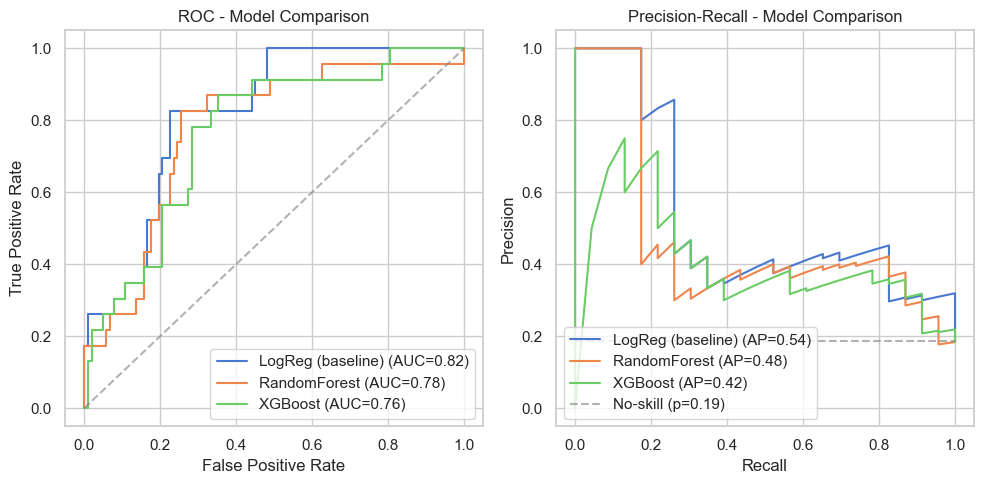

In [12]:
# Jämför ROC- och Precision-Recall-kurvor för alla modeller
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for r in results:
    fpr, tpr, _ = roc_curve(y_test, r["proba"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{r["name"]} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], "--", alpha=0.6, color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Model Comparison")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
for r in results:
    prec, rec, _ = precision_recall_curve(y_test, r["proba"])
    ap = average_precision_score(y_test, r["proba"])
    plt.plot(rec, prec, label=f'{r["name"]} (AP={ap:.2f})')

plt.hlines(
    y=y.mean(),
    xmin=0,
    xmax=1,
    linestyles="--",
    alpha=0.6,
    color="grey",
    label=f"No-skill (p={y.mean():.2f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall - Model Comparison")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig(paths.images_dir / "roc_pr_side_by_side.png", bbox_inches="tight", dpi=150)
plt.show()

---
## Utvärdering av bästa modell


### Klassificeringsrapporter

In [13]:
# Välj bästa modell (AUC)
best = max(results, key=lambda r: r["auc"])
best_name, best_model = best["name"], best["model"]

# Klassificeringsrapport vid threshold 0.50
y_pred_05 = (best["proba"] >= 0.50).astype(int)
print("\nClassification Report @ threshold = 0.50")
print(
    classification_report(
        y_test, y_pred_05, target_names=["Active", "Churned"], digits=3
    )
)

# Klassificeringsrapport vid threshold som maximerar F1
thr_best = best["best_thr"]
y_pred_best = (best["proba"] >= thr_best).astype(int)
print(f"\nClassification Report @ best F1 threshold = {thr_best:.2f}")
print(
    classification_report(
        y_test, y_pred_best, target_names=["Active", "Churned"], digits=3
    )
)


Classification Report @ threshold = 0.50
              precision    recall  f1-score   support

      Active      0.948     0.716     0.816       102
     Churned      0.396     0.826     0.535        23

    accuracy                          0.736       125
   macro avg      0.672     0.771     0.675       125
weighted avg      0.846     0.736     0.764       125


Classification Report @ best F1 threshold = 0.53
              precision    recall  f1-score   support

      Active      0.952     0.775     0.854       102
     Churned      0.452     0.826     0.585        23

    accuracy                          0.784       125
   macro avg      0.702     0.800     0.719       125
weighted avg      0.860     0.784     0.804       125



### Confusion-matriser

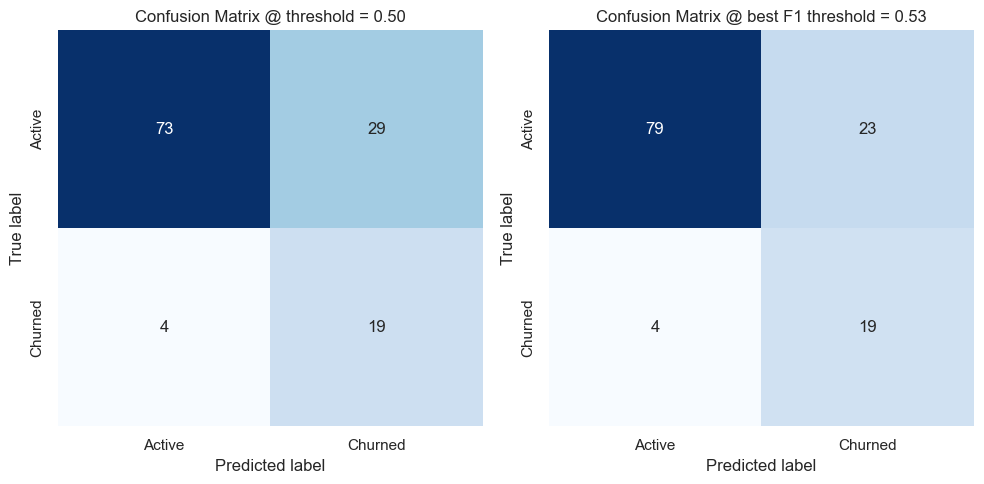

In [14]:
# Jämför confusion-matriser
plt.figure(figsize=(10, 5))

# Threshold 0.50
plt.subplot(1, 2, 1)
cm_05 = confusion_matrix(y_test, y_pred_05)
sns.heatmap(
    cm_05,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Active", "Churned"],
    yticklabels=["Active", "Churned"],
)
plt.title("Confusion Matrix @ threshold = 0.50")
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Best F1
plt.subplot(1, 2, 2)
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(
    cm_best,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Active", "Churned"],
    yticklabels=["Active", "Churned"],
)
plt.title(f"Confusion Matrix @ best F1 threshold = {thr_best:.2f}")
plt.xlabel("Predicted label")
plt.ylabel("True label")


plt.tight_layout()
plt.savefig(paths.images_dir / "cm_side_by_side.png", dpi=150, bbox_inches="tight")
plt.show()

---
## Feature Importance & Förklarbarhet

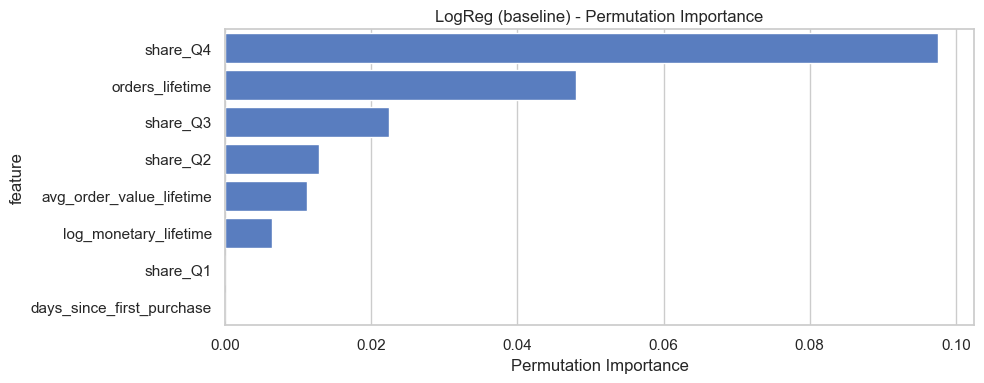

,feature,importance_mean,importance_std
6,share_Q4,0.0976,0.027434
0,orders_lifetime,0.0480,0.011314
5,share_Q3,0.0224,0.017083
4,share_Q2,0.0128,0.019333
1,avg_order_value_lifetime,0.0112,0.006400
7,log_monetary_lifetime,0.0064,0.010613
3,share_Q1,0.0000,0.010119
2,days_since_first_purchase,0.0000,0.016781


In [15]:
# Jämför feature importance
def unwrap_estimator(m):
    """Plocka fram estimatorn om modellen ligger i en Pipeline."""
    return m.named_steps.get("clf") if isinstance(m, Pipeline) else m


est = unwrap_estimator(best_model)
is_tree = isinstance(est, (RandomForestClassifier, XGBClassifier))

if is_tree:
    # SHAP (för träd-baserade modeller)
    explainer = shap.TreeExplainer(est)
    try:
        sv = explainer(X_test_pi)
        shap.summary_plot(sv.values, X_test_pi, show=False)
        plt.show()

        # Tabell med topp 10 features (genomsnittligt absolut SHAP-värde)
        shap_mean = np.abs(sv.values).mean(0)
        shap_df = pd.DataFrame(
            {"feature": X_test_pi.columns, "mean_abs_shap": shap_mean}
        )
        shap_df = shap_df.sort_values("mean_abs_shap", ascending=False)
        display(shap_df.head(10))

    except Exception:
        shap_vals = explainer.shap_values(X_test_pi)
        shap.summary_plot(shap_vals, X_test_pi, show=False)
        plt.show()

else:
    # Permutation (för icke-trädmodeller, t.ex. Logistic Regression)
    perm = permutation_importance(
        best_model,
        X_test_pi,
        y_test,
        n_repeats=PERM_REPEATS,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    perm_df = pd.DataFrame(
        {
            "feature": feature_names,
            "importance_mean": perm.importances_mean,
            "importance_std": perm.importances_std,
        }
    ).sort_values("importance_mean", ascending=False)
    plt.figure(figsize=(10, 4))
    sns.barplot(data=perm_df, x="importance_mean", y="feature")
    plt.xlabel("Permutation Importance")
    plt.title(f"{best_name} - Permutation Importance")
    plt.tight_layout()
    plt.savefig(paths.images_dir / f"permutation_importance_{best_name}.png", dpi=150)
    plt.show()

    # Visa topp 10 features som tabell
    display(perm_df.head(10))

---
## Kalibrering av sannolikheter


### Jämförelse före/efter kalibrering

In [16]:
calib = calibrate_model(best_model, X_train_pi, y_train, method="isotonic")

# Utvärdera modell före och efter kalibrering
res_uncal = evaluate_model("Uncalibrated", best_model, X_train, y_train, X_test, y_test)
res_cal = evaluate_model("Calibrated", calib, X_train, y_train, X_test, y_test)

eval_compare = pd.DataFrame(
    [
        {
            "Model": r["name"],
            "AUC": r["auc"],
            "F1@0.50": r["f1_05"],
            "BestF1": r["f1_best"],
            "BestThr": r["best_thr"],
            "Precision@10": r["precision_at_k"],
        }
        for r in [res_uncal, res_cal]
    ]
).round(3)

display(eval_compare)

,Model,AUC,F1@0.50,BestF1,BestThr,Precision@10
0,Uncalibrated,0.818,0.535,0.585,0.528,0.500
1,Calibrated,0.827,0.368,0.585,0.271,0.583


### Calibration curves

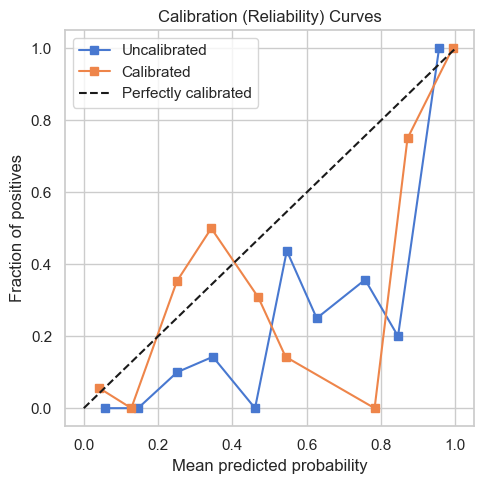

In [17]:
# Reliability curves (Calibration Plots)
plt.figure(figsize=(5, 5))

# Uncalibrated
prob_uncal = res_uncal["proba"]
frac_pos_uncal, mean_pred_uncal = calibration_curve(y_test, prob_uncal, n_bins=10)
plt.plot(mean_pred_uncal, frac_pos_uncal, "s-", label="Uncalibrated")

# Calibrated
prob_cal = res_cal["proba"]
frac_pos_cal, mean_pred_cal = calibration_curve(y_test, prob_cal, n_bins=10)
plt.plot(mean_pred_cal, frac_pos_cal, "s-", label="Calibrated")

# Perfect calibration (referenslinje)
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration (Reliability) Curves")
plt.legend()
plt.tight_layout()
plt.savefig(paths.images_dir / "calibration_curves.png", dpi=150)
plt.show()

---
## Exporter


### Träna slutmodell & generera scoring-tabell

In [18]:
# Versionsmärkning av modell (för BI och metadata)
model_version = "v1"

# Träna slutmodell på hela datasetet
base_model_full = clone(best_model)
base_model_full.fit(X, y)

# Kalibrera vid behov (via hjälpfunktion i model.py)
if USE_CALIBRATED_FOR_EXPORT:
    export_model = calibrate_model(base_model_full, X.loc[:, feature_names], y)
    export_model_name = best_name + "+Calibrated"
    calib_used = "calibrated"
else:
    export_model = base_model_full
    export_model_name = best_name
    calib_used = "none"

# Exportera scoring-tabell för samtliga kunder
feats_export = train_full_and_export(
    best_model=best_model,
    X=X,
    y=y,
    feats=feats_model,
    reference_date=reference_date,
    paths=paths,
    use_calibrated=USE_CALIBRATED_FOR_EXPORT,
    model_name_hint=best_name,
    random_state=RANDOM_STATE,
)

display(feats_export.head())

,customer_id,first_purchase,last_purchase,orders_lifetime,monetary_lifetime,frequency_90d,monetary_90d,share_Q1,share_Q2,share_Q3,share_Q4,recency,days_since_first_purchase,avg_order_value_lifetime,avg_order_value_90d,is_weekly_buyer,churned,risk_score,risk_band,model_name,model_version,scored_at,reference_date
0,1,2024-01-25,2024-12-29,14,10366.429796,3.0,1648.591380,0.285714,0.142857,0.214286,0.357143,32,371,740.459271,549.530460,0,0,0.0676,Low,LogReg (baseline),v1,2025-09-28T01:02:58.750041+00:00,2025-01-30T00:00:00
1,2,2023-12-22,2024-10-31,10,6414.793072,0.0,0.000000,0.300000,0.100000,0.300000,0.300000,91,405,641.479307,0.000000,0,1,0.3433,High,LogReg (baseline),v1,2025-09-28T01:02:58.750041+00:00,2025-01-30T00:00:00
2,3,2024-01-25,2024-11-23,9,6775.672899,2.0,1222.774479,0.222222,0.333333,0.222222,0.222222,68,371,752.852544,611.387239,0,0,0.5022,High,LogReg (baseline),v1,2025-09-28T01:02:58.750041+00:00,2025-01-30T00:00:00
3,4,2024-02-04,2024-10-21,10,7179.529642,0.0,0.000000,0.100000,0.100000,0.400000,0.400000,101,361,717.952964,0.000000,0,1,0.1112,Low,LogReg (baseline),v1,2025-09-28T01:02:58.750041+00:00,2025-01-30T00:00:00
4,5,2024-01-03,2025-01-12,15,12459.663970,4.0,2790.893819,0.400000,0.133333,0.333333,0.133333,18,393,830.644265,697.723455,0,0,0.4094,High,LogReg (baseline),v1,2025-09-28T01:02:58.750041+00:00,2025-01-30T00:00:00


### Kvalitetskontroll 

In [19]:
# Summera riskband
band_summary = (
    feats_export.groupby("risk_band", observed=False)
    .agg(
        n=("risk_score", "size"),
        avg_score=("risk_score", "mean"),
    )
    .round(4)
    .reset_index()
    .sort_values("risk_band")
)

display(band_summary)

# Spara riskbandsöversikt till CSV (för BI)
band_summary.to_csv(paths.model_dir / "riskband_summary.csv", index=False)

# Exempel på kunder i olika risknivåer
top10 = feats_export.nlargest(10, "risk_score")[
    ["customer_id", "risk_score", "risk_band"]
]
bottom10 = feats_export.nsmallest(10, "risk_score")[
    ["customer_id", "risk_score", "risk_band"]
]
random10 = feats_export.sample(10, random_state=RANDOM_STATE)[
    ["customer_id", "risk_score", "risk_band"]
]

side_by_side = pd.concat(
    [
        top10.reset_index(drop=True),
        bottom10.reset_index(drop=True),
        random10.reset_index(drop=True),
    ],
    axis=1,
    keys=["Top 10 (highest risk)", "Bottom 10 (lowest risk)", "Random 10"],
)
display(side_by_side)

,risk_band,n,avg_score
0,Low,125,0.0817
1,Medium,125,0.2494
2,High,125,0.4719
3,Critical,125,0.7791


Top 10 (highest risk)                      Bottom 10 (lowest risk)  \
            customer_id risk_score risk_band             customer_id   
0                    94     0.9704  Critical                     326   
1                    83     0.9696  Critical                     405   
2                   412     0.9604  Critical                      25   
3                   185     0.9595  Critical                     103   
4                   219     0.9534  Critical                     139   
5                   193     0.9497  Critical                     417   
6                    50     0.9445  Critical                     329   
7                   166     0.9445  Critical                     460   
8                   255     0.9288  Critical                     418   
9                   396     0.9268  Critical                     334   

                         Random 10                       
  risk_score risk_band customer_id risk_score risk_band  
0     0.0018       Low         362     0.7967  Critical  
1     0.0057       Low          74     0.6146  Critical  
2     0.0089       Low         375     0.1867    Medium  
3     0.0089       Low         156     0.4533      High  
4     0.0094       Low         105     0.3323    Medium  
5     0.0095       Low         395     0.4015      High  
6     0.0112       Low         378     0.1308       Low  
7     0.0121       Low         125     0.8460  Critical  
8     0.0139       Low          69     0.1722    Medium  
9     0.0141       Low         451     0.2120    Medium

### Spara resultat & metadata

In [20]:
# Exportera analysresultat (för rapport/BI)
if "compare_df" in globals():
    compare_df.to_csv(paths.data_dir / "model_comparison.csv", index=False)

if "cv_df" in globals():
    cv_df.to_csv(paths.data_dir / "model_cv_auc.csv", index=False)

if "perm_df" in globals():
    perm_df.to_csv(paths.data_dir / f"permutation_importance_{best_name}.csv", index=False)

# Spara slutmodell och metadata (för produktionsbruk/BI)
model_path = paths.model_dir / f"final_model_{export_model_name}.joblib"
joblib.dump(export_model, model_path)

# Metadata för spårbarhet och reproducerbarhet
meta = {
    # Features och parametrar
    "train_cols": feature_names,
    "created_at_utc": pd.Timestamp.utcnow().isoformat(),
    "churn_days": CHURN_DAYS,
    "reference_date": reference_date.isoformat(),
    # Modellinfo
    "best_model_name": export_model_name,
    "export_model_class": type(export_model).__name__,
    "calibration": globals().get("calib_used", "none"),
    "random_state": RANDOM_STATE,
    # Versioner
    "sklearn_version": __import__("sklearn").__version__,
    "xgboost_version": __import__("xgboost").__version__,
    "pandas_version": pd.__version__,
    "numpy_version": np.__version__,
    "model_version": model_version,
}

# Spara metadata
with open(paths.model_dir / "final_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)